In [71]:
!yes | pip uninstall torchvison
!pip install -qU torchvision

yes: standard output: Broken pipe


In [72]:
!pip install pillow

In [73]:
!pip install requests

# MNIST Training using PyTorch

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial will show how to train and test an MNIST model on SageMaker using PyTorch.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).


In [74]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-pytorch-mnist"

role = sagemaker.get_execution_role()

In [75]:
import json
metadata = json.load(open("/opt/ml/metadata/resource-metadata.json","r"))
bucket = metadata["UserProfileName"]
bucket

'28743102-e626-46b1-b5f1-d312c82e1bcb'

In [76]:
bucket

'28743102-e626-46b1-b5f1-d312c82e1bcb'

In [78]:
from boto3 import client

conn = client('s3')  # again assumes boto.cfg setup, assume AWS S3
for key in conn.list_objects(Bucket=bucket)['Contents']:
    print(key['Key'])

data/1.11.344.6148.65065.152707.6306186.96124460631032360342854182473_5.50.165.1847.21251.931697.4943068.66587612922852477819742239754_9.59.156.4421.74552.215908.6904659.49034716993854402263648069793.dcm
data/1.12.746.8025.62058.949442.1929181.53704693946484206476797649267_1.43.318.8932.46424.646527.5125264.34607190288155359632618069574_1.10.438.7074.32125.900008.4092280.70162125893606125565043933402.dcm
data/1.12.967.5116.19356.946072.2432445.47831750788890784530891947041_7.73.122.6517.38425.389142.3671342.37329354064982022344298925837_1.94.287.6068.64042.801707.8730888.96213932843756638999515284232.dcm
data/1.13.120.6964.99330.189205.6937115.13568674261194149132466639708_8.41.552.3169.48654.890784.1114012.14201826718081841047037652106_1.12.716.5329.19210.710458.9194349.92481456069811815581169388576.dcm
data/1.13.142.7833.71939.935224.5464397.45905719824188091537499465124_4.25.566.4222.23306.762121.7943945.56687295583391761904186824676_1.16.435.9740.47447.416936.9741465.54444623486982

In [80]:
# Downloading Data from S3

import boto3
import botocore
from boto3 import client
import os
os.mkdir("data")
os.mkdir("labels")
BUCKET_NAME = bucket
c = 0
conn = client('s3')  # again assumes boto.cfg setup, assume AWS S3
for key in conn.list_objects(Bucket=bucket)['Contents']:
    print(key['Key'])
    KEY = key['Key']
    s3 = boto3.resource('s3')
    try:
        s3.Bucket(BUCKET_NAME).download_file(KEY, f"{key['Key']}")
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise
    c = c+1


data/1.11.344.6148.65065.152707.6306186.96124460631032360342854182473_5.50.165.1847.21251.931697.4943068.66587612922852477819742239754_9.59.156.4421.74552.215908.6904659.49034716993854402263648069793.dcm
data/1.12.746.8025.62058.949442.1929181.53704693946484206476797649267_1.43.318.8932.46424.646527.5125264.34607190288155359632618069574_1.10.438.7074.32125.900008.4092280.70162125893606125565043933402.dcm
data/1.12.967.5116.19356.946072.2432445.47831750788890784530891947041_7.73.122.6517.38425.389142.3671342.37329354064982022344298925837_1.94.287.6068.64042.801707.8730888.96213932843756638999515284232.dcm
data/1.13.120.6964.99330.189205.6937115.13568674261194149132466639708_8.41.552.3169.48654.890784.1114012.14201826718081841047037652106_1.12.716.5329.19210.710458.9194349.92481456069811815581169388576.dcm
data/1.13.142.7833.71939.935224.5464397.45905719824188091537499465124_4.25.566.4222.23306.762121.7943945.56687295583391761904186824676_1.16.435.9740.47447.416936.9741465.54444623486982

In [90]:
# Converting downloaded data to png

# Dcm to Png
!pip install pydicom
import pydicom as dicom
import pydicom
import json
import os
from pathlib import Path
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pydicom import dcmread
import os
import pickle
from PIL import Image
import numpy as np
from PIL import Image
import PIL

def read_xray(path, voi_lut=True, fix_monochrome=True):
    try:
        print("Converting to PNG .........................")
        dicom = dcmread(path, force=True)
        print(dicom.SOPInstanceUID, ">>>>>>", dicom.InstanceNumber, ">>>>>", dicom.SeriesInstanceUID)
        #if voi_lut:
        if voi_lut and len(dicom.get("VOILUTSequence", [])):
            data = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            data = dicom.pixel_array
        if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
            data = np.amax(data) - data
        data = data - np.min(data)
        data = data / np.max(data)
        data = (data * 255).astype(np.uint8)
        return data
    except Exception as e:
        print(e, ">>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        return "corrupt"

In [92]:
files_ = Path("downloaded").rglob('*.dcm')
print(files_)
c = 0
for i in files_:
    try:
        print(i)
        img = read_xray(i)
        with open("filename.pkl", 'wb') as f:
            pickle.dump(img, f)
        ims = pickle.load(open("filename.pkl", "rb"))
        norm = (ims.astype(np.float) - ims.min()) * 255.0 / (ims.max() - ims.min())
        Image.fromarray(norm.astype(np.uint8)).save(f"training_data_png/{c}.png")
        c = c + 1
        print(c, "Done")
    except Exception as e:
        print(e)

<generator object Path.rglob at 0x7ff80c460dd0>
downloaded/training_dicom7.dcm
Converting to PNG .........................
5.78.165.8753.87981.158522.9691017.31219635449818643820871103152 >>>>>> None >>>>> 3.47.512.4308.88844.978974.8333351.93114562641818086253127085393
1 Done
downloaded/training_dicom61.dcm
Converting to PNG .........................
2.86.966.1249.12896.142851.7012656.52807079842961239965702982579 >>>>>> None >>>>> 7.64.955.8263.18575.409446.3640855.51882253620436712390570662146
2 Done
downloaded/training_dicom25.dcm
Converting to PNG .........................
2.16.731.2653.65463.449091.8917667.41222623441020182497739876237 >>>>>> None >>>>> 9.32.558.1632.35311.289135.5169772.59783536133376193141554188494
3 Done
downloaded/training_dicom43.dcm
Converting to PNG .........................
1.13.122.7584.87360.909434.2488129.94176012338520824434242075633 >>>>>> None >>>>> 3.96.203.5623.14458.536123.9923452.32605908197158403490129812583


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


4 Done
downloaded/training_dicom106.dcm
Converting to PNG .........................
'FileDataset' object has no attribute 'SOPInstanceUID' >>>>>>>>>>>>>>>>>>>>>>>>>>>>>
'str' object has no attribute 'astype'
downloaded/training_dicom70.dcm
Converting to PNG .........................
4.82.527.1212.26227.454819.5870202.76689373061364734599229546869 >>>>>> None >>>>> 6.56.270.8134.30856.155751.4247617.79007716620653022415356363204
5 Done
downloaded/training_dicom34.dcm
Converting to PNG .........................
7.43.194.2532.19555.984100.4655679.20909524581407096942960578198 >>>>>> None >>>>> 1.12.132.8397.90029.722208.3375529.98323350099395856927194532597
6 Done
downloaded/training_dicom16.dcm
Converting to PNG .........................
5.13.739.6323.95176.911483.1047870.19058515666082043809459233223 >>>>>> None >>>>> 4.62.143.1766.49452.390831.3652060.16908970487932721084260947354
7 Done
downloaded/training_dicom52.dcm
Converting to PNG .........................
7.58.225.7976.30161.191

## Data
### Getting the data



In [86]:
from torchvision.datasets import MNIST
from torchvision import transforms

MNIST.mirrors = ["https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/"]

MNIST(
    "data",
    download=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Uploading the data to S3
We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.


In [87]:
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://28743102-e626-46b1-b5f1-d312c82e1bcb/sagemaker/DEMO-pytorch-mnist


## Train
### Training script
The `mnist.py` script provides all the code we need for training and hosting a SageMaker model (`model_fn` function to load a model).
The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: The number of gpus available in the current container.
* `SM_CURRENT_HOST`: The name of the current container on the container network.
* `SM_HOSTS`: JSON encoded list containing all the hosts .

Supposing one input channel, 'training', was used in the call to the PyTorch estimator's `fit()` method, the following will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (``if __name__=='__main__':``) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

For example, the script run by this notebook:

In [94]:
!pygmentize code/mnist.py

import argparse
import json
import logging
import os
import sys
#import sagemaker_containers
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

import shlex, subprocess
# def install(package):
#     os.system("pip install " +  package)
    
# install('pillow')
# install('requests')
# install('pydicom')
from PIL import Image
import requests
import pydicom

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,

### Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters. In this case we are going to run our training job on 2 ```ml.c4.xlarge``` instances. But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)). The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the `mnist.py` script above.


In [95]:
!pip install --upgrade sagemaker==2.110.0

In [96]:
from sagemaker.pytorch import PyTorch


In [97]:
!pip show sagemaker | grep Version

Version: 2.110.0


In [100]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="mnist.py",
    role=role,
    py_version="py38",
    framework_version="1.11.0",
    instance_count=2,
    instance_type="ml.c5.2xlarge",
    hyperparameters={"epochs": 1, "backend": "gloo"},
    dependencies=['code/requirements.txt'],
    source_dir = "code",
)

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [109]:
estimator.fit({"training": inputs})

2022-12-15 09:06:13 Starting - Starting the training job...
2022-12-15 09:06:36 Starting - Preparing the instances for trainingProfilerReport-1671095172: InProgress
.........
2022-12-15 09:08:09 Downloading - Downloading input data...
2022-12-15 09:08:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-15 09:08:30,097 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-15 09:08:30,099 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-15 09:08:30,106 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-15 09:08:30,107 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-15 09:08:30,257 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.

## Host
### Create endpoint
After training, we use the `PyTorch` estimator object to build and deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference.

As mentioned above we have implementation of `model_fn` in the `mnist.py` script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in `mnist.py`. Here we will deploy the model to a single ```ml.m4.xlarge``` instance.

In [25]:
estimator.__dict__


{'framework_version': '1.11.0',
 'py_version': 'py38',
 'role': 'arn:aws:iam::883411003189:role/service-role/AmazonSageMaker-ExecutionRole-20220706T141355',
 'instance_count': 2,
 'instance_type': 'ml.c5.2xlarge',
 'keep_alive_period_in_seconds': None,
 'instance_groups': None,
 'volume_size': 30,
 'volume_kms_key': None,
 'max_run': 86400,
 'input_mode': 'File',
 'metric_definitions': None,
 'model_uri': None,
 'model_channel_name': 'model',
 'code_uri': None,
 'code_channel_name': 'code',
 'source_dir': 'code',
 'git_config': None,
 'container_log_level': 20,
 '_hyperparameters': {'epochs': 1,
  'backend': 'gloo',
  'sagemaker_submit_directory': 's3://sagemaker-ap-southeast-1-883411003189/pytorch-training-2022-12-15-04-55-05-509/source/sourcedir.tar.gz',
  'sagemaker_program': 'mnist.py',
  'sagemaker_container_log_level': 20,
  'sagemaker_job_name': 'pytorch-training-2022-12-15-04-55-05-509',
  'sagemaker_region': 'ap-southeast-1'},
 'code_location': None,
 'entry_point': 'mnist.py'

In [26]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.c5.2xlarge")

-----!

### Evaluate

You can use the test images to evalute the endpoint. The accuracy of the model depends on how many it is trained. 

In [27]:
!ls data/MNIST/raw

t10k-images-idx3-ubyte	   train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte	   train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [28]:
import gzip
import numpy as np
import random
import os

data_dir = "data/MNIST/raw"
with gzip.open(os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "rb") as f:
    images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28).astype(np.float32)

mask = random.sample(range(len(images)), 16)  # randomly select some of the test images
mask = np.array(mask, dtype=np.int)
data = images[mask]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


In [29]:
mask

array([2529, 8464, 9926, 3929, 6169,  392, 4305, 2118, 4274, 2184, 5513,
       3174, 6799, 8376, 3933, 3165])

In [30]:
pic = np.random.rand(1,28,28).astype(np.float32)

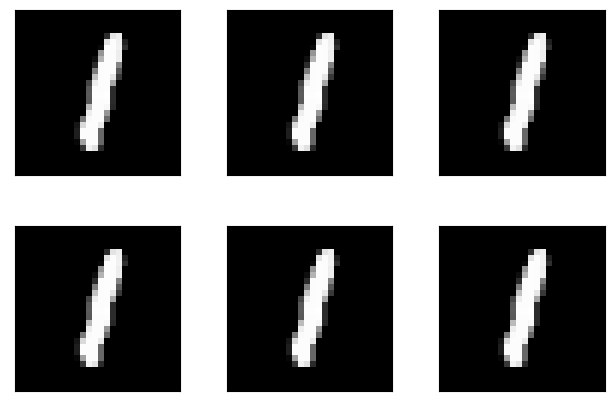

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(data[0], cmap='gray', interpolation='none')
  # plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [21]:
response = predictor.predict(np.expand_dims(data, axis=1))
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "Requested unsupported ContentType in content_type application/x-npy
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 142, in transform
    result = self._run_handler_function(
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 276, in _run_handler_function
    result = func(*argv_context)
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 259, in _default_transform_fn
    data = self._run_handler_function(self._input_fn, *(input_data, content_type))
  File "/opt/conda/lib/python3.8/site-packages/sagemaker_inference/transformer.py", line 272, in _run_handler_function
    result = func(*argv)
  File "/opt/ml/model/code/mnist.py", line 241, in input_fn
    raise Exception(f'Requested unsupported ContentType in content_type {content_type}')
Exception: Requested unsupported ContentType in content_type application/x-npy
". See https://ap-south-1.console.aws.amazon.com/cloudwatch/home?region=ap-south-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-2022-10-11-07-17-55-618 in account 023180687239 for more information.

### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [ ]:
predictor.__dict__

In [ ]:
predictor.content_type = 'application/x-npy'

In [ ]:
sagemaker_session.delete_endpoint(endpoint_name=predictor.endpoint_name)

In [ ]:
callable

In [ ]:
dir(predictor)

In [ ]:
predictor.predict(pic.reshape(28,28))

In [23]:
import json


In [24]:
predictor.endpoint_name 

'pytorch-training-2022-10-11-08-07-06-661'

In [43]:
import boto3

client = boto3.client('sagemaker-runtime')

custom_attributes = "c000b4f9-df62-4c85-a0bf-7c525f9104a4"  # An example of a trace ID.
endpoint_name = predictor.endpoint_name                                        # Your endpoint name.
content_type = "application/json"                                        # The MIME type of the input data in the request body.
accept = "application/json"                                              # The desired MIME type of the inference in the response.
payload = json.dumps({"url":"http://rasbt.github.io/mlxtend/user_guide/data/mnist_data_files/mnist_data_10_0.png"})                                           # Payload for inference.
response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    CustomAttributes=custom_attributes, 
    ContentType=content_type,
    Accept=accept,
    Body=payload
    )

print(response)   

{'ResponseMetadata': {'RequestId': '0957ab6d-569b-477a-aef0-7481a935eecb', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0957ab6d-569b-477a-aef0-7481a935eecb', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Tue, 11 Oct 2022 08:23:34 GMT', 'content-type': 'application/json', 'content-length': '207'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7efc7f467550>}


In [44]:
from pprint import pprint

In [45]:
pprint(response) 

{'Body': <botocore.response.StreamingBody object at 0x7efc7f467550>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '207',
                                      'content-type': 'application/json',
                                      'date': 'Tue, 11 Oct 2022 08:23:34 GMT',
                                      'x-amzn-invoked-production-variant': 'AllTraffic',
                                      'x-amzn-requestid': '0957ab6d-569b-477a-aef0-7481a935eecb'},
                      'HTTPStatusCode': 200,
                      'RequestId': '0957ab6d-569b-477a-aef0-7481a935eecb',
                      'RetryAttempts': 0}}


In [46]:
r = json.load(response["Body"])

In [47]:
r

[[-3.0102062225341797,
  -2.48018217086792,
  -1.5776013135910034,
  -2.6531476974487305,
  -3.039762020111084,
  -1.8981196880340576,
  -2.262784481048584,
  -4.358467102050781,
  -1.3877885341644287,
  -3.6531260013580322]]

In [51]:
np.argmax(r[0])

8

In [55]:
r[0]

[-3.0102062225341797,
 -2.48018217086792,
 -1.5776013135910034,
 -2.6531476974487305,
 -3.039762020111084,
 -1.8981196880340576,
 -2.262784481048584,
 -4.358467102050781,
 -1.3877885341644287,
 -3.6531260013580322]

In [ ]:
import torch

In [ ]:
torch.FloatTensor(pic)

In [ ]:
pic.astype("float32").tolist()

In [ ]:
pic.shape

In [ ]:
pic

In [ ]:
torch.tensor(pic, dtype=torch.float32)

In [ ]:
Image

In [ ]:

Image.open(req.get(url, stream=True).raw)

In [ ]:
def input_fn(request_body, content_type='application/json'):
    logger.info('Deserializing the input data.')
    import requests
    import numpy as np
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if content_type == 'application/json':
        input_data = json.loads(request_body)
        url = input_data['url']
        logger.info(f'Image url: {url}')
        # resp = requests.get(url, stream=True)
        # raw_data = resp.raw
        image_data = Image.open(requests.get(url, stream=True).raw)
        
        image_transform = transforms.Compose([
            transforms.Resize(size=28),
        ])
        # logger.debug("image_data - {}",image_data)
        # data = image_transform(image_data)
        # # logger.debug("data - {}",data)
        # data = np.asarray(data)
        # # logger.debug("data - {}",data)
        # data = torch.tensor(data, dtype=torch.float32, device=device)
        # logger.debug("data - {}",data)
        return image_transform(image_data)
    raise Exception(f'Requested unsupported ContentType in content_type {content_type}')

In [52]:
import logging,sys
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
from PIL import Image
import requests
import numpy as np
import torch

In [53]:
request_body = json.dumps({"url":"http://rasbt.github.io/mlxtend/user_guide/data/mnist_data_files/mnist_data_10_0.png"})    
input_data = json.loads(request_body)
url = input_data['url']
logger.info(f'Image url: {url}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# resp = requests.get(url, stream=True)
# raw_data = resp.raw
image_data = Image.open(requests.get(url, stream=True).raw).convert('L')

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28)),
])
print(image_data)
data = image_transform(image_data)
print(data.shape)
data = np.asarray(data)
print(data.shape)
data = torch.tensor(data, dtype=torch.float32, device=device)
print(data.shape)

Image url: http://rasbt.github.io/mlxtend/user_guide/data/mnist_data_files/mnist_data_10_0.png
<PIL.Image.Image image mode=L size=353x370 at 0x7EFC7F3B8990>
torch.Size([1, 28, 28])
(1, 28, 28)
torch.Size([1, 28, 28])


In [ ]:
im.shape

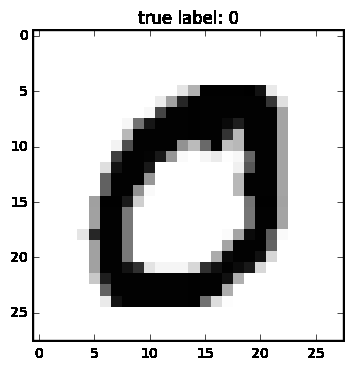

In [54]:
image_data